In [1]:
import lumpyrem as lm
import pandas as pd

# set the lumprem folder
lm_workspace = os.path.join('.','flopy','lumprem')

if not os.path.exists(lm_workspace):
    os.makedirs(lm_workspace)

In [2]:
# setup models
# landuse models for recharge, evap and gw abstraction
lr_lu1 = lm.lumprem.Model('lu1', workspace=lm_workspace, vegfile=(1.0,1.0), irrigfile = (0, 0)) # no irrigation
lr_lu2 = lm.lumprem.Model('lu2', workspace=lm_workspace, vegfile=(1.0,1.0), irrigfile = (1, 0.5))

In [3]:
# make a list of the model objets
lr_list = [lr_lu1, lr_lu2]

In [4]:
# write and run each model
for lr in lr_list:
    lr.write_model(start_date='01/01/2010', end_date='01/01/2020', noutdays='monthly')
    lr.run_model()

LUMPREM model input file written to: 
.\flopy\lumprem\lr_lu1.in
PEST template file written to: 
.\flopy\lumprem\lr_lu1.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_lu1.in read ok.
 - file lumprem_variables.rec written ok.
 - file rain.dat read ok.
 - file epot.dat read ok.
 - file lr_lu1.out written ok.
 - file lr_lu1.csv written ok.

LUMPREM model input file written to: 
.\flopy\lumprem\lr_lu2.in
PEST template file written to: 
.\flopy\lumprem\lr_lu2.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_lu2.in read ok.
 - file lumprem_variables.rec written ok.
 - file rain.dat read ok.
 - file epot.dat read ok.
 - file lr_lu2.out written ok.
 - file lr_lu2.csv written ok.



In [5]:
# check the outputs

lr_results = pd.DataFrame()
for lr in lr_list:
    df = lr.get_results()
    lr_results = pd.concat([lr_results, df])

lr_results.head()

,days,vol_upper,vol_lower,vol_drain,vol_macro,del_vol_upper,del_vol_lower,del_vol_drain,del_vol_macro,rainfall,...,workspace,maxvol_br,extravol_br,gamma_br,ks_br,m_br,l_br,vol_br,epotfile_br,epot_br_all
0,0,0.250000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0000,...,.\flopy\lumprem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31,0.248326,0.0,0.006771,0.0,-0.001674,0.0,0.006771,0.0,0.0708,...,.\flopy\lumprem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,0.197971,0.0,0.002295,0.0,-0.050355,0.0,-0.004476,0.0,0.0068,...,.\flopy\lumprem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90,0.175276,0.0,0.000965,0.0,-0.022695,0.0,-0.001331,0.0,0.0218,...,.\flopy\lumprem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,120,0.217376,0.0,0.003521,0.0,0.042100,0.0,0.002556,0.0,0.1022,...,.\flopy\lumprem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


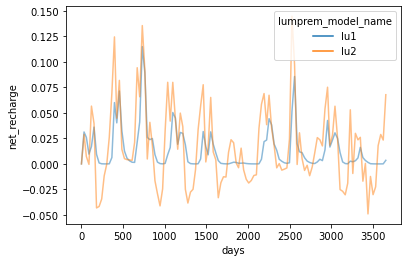

In [6]:
# plot the model results
import seaborn as sb
sb.lineplot(data=lr_results, x='days',y='net_recharge', hue='lumprem_model_name', alpha=0.5);

# Setup Flopy model. 
This model is adapted from the Flopy tutorial noteboo: flopy3_mf6_obs_ts_tas.ipynb 

In [7]:
import pandas as pd 
import matplotlib.pyplot as plt

import os
import sys
import numpy as np
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

# init paths
exe_name = 'mf6'

sim_path = os.path.join('flopy', 'mf6model')
# make the directory if it does not exist
if not os.path.isdir(sim_path):
    os.makedirs(sim_path)
  
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.20.2
flopy version: 3.3.3


In [8]:
# create simulation
sim_name = 'lumpyflo'
model_name = 'gwf'


# grid dimensions
nlay = 3
ncols = 10
nrow = 15
top = 50.


sim = flopy.mf6.MFSimulation(sim_name=sim_name, version='mf6', exe_name='mf6',
                   sim_ws=sim_path)

tdis_rc = [(1.0, 1, 1.0),(3650, 10*12, 1.0)]

tdis_package = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, time_units='DAYS', nper=len(tdis_rc), perioddata=tdis_rc)
model = flopy.mf6.ModflowGwf(sim, modelname=model_name,
                             model_nam_file='{}.nam'.format(model_name))
ims_package = flopy.mf6.modflow.mfims.ModflowIms(
    sim, print_option='SUMMARY', complexity='SIMPLE', outer_hclose=0.0001, 
    outer_maximum=500, under_relaxation='NONE', inner_maximum=100,
    inner_hclose=0.0001, rcloserecord=0.001, linear_acceleration='CG',
    scaling_method='NONE', reordering_method='NONE', relaxation_factor=0.97)
sim.register_ims_package(ims_package, [model.name])
bot_data = [-100 for x in range(150)]
dis_package = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    model, nlay=nlay, nrow=nrow, ncol=ncols, delr=500.0, delc=500.0, top=50.0, 
    botm=[5.0, -10.0, {'factor': 1.0, 'data': bot_data}],
    filename='{}.dis'.format(model_name))
ic_package = flopy.mf6.modflow.mfgwfic.ModflowGwfic(
    model, strt=50.0, filename='{}.ic'.format(model_name))
npf_package = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    model, save_flows=True, icelltype=[1, 0, 0], k=[5.0, 0.1, 4.0],
    k33=[0.5, 0.005, 0.1])
oc_package = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    model, budget_filerecord='child_pkgs.cbc',head_filerecord='child_pkgs.hds',
    headprintrecord=['COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL'],
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')], 
    printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), ('BUDGET', 'LAST')])
sto_package = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(
    model, save_flows=True, iconvert=1, ss=0.000001, sy=0.2, steady_state={0: True},
    transient={1: True})

In [9]:
# create constant head bc around model domain = top
chdspd ={}
chdspd_arr = []
for layer in range(nlay-1):
    for col in [0,ncols-1]:
        for row in range(nrow-1):
            chdspd_arr.append(((layer, row, col), top, 'chd'))

for sp in range(len(tdis_rc)):
    chdspd[sp] = chdspd_arr

chd = flopy.mf6.ModflowGwfchd(model, stress_period_data=chdspd, boundnames=True)

# build obs data
chd_obs = {('chd_flow.csv'): [('chd', 'CHD', 'chd')]}

# initialize obs package
chd.obs.initialize(digits=9, print_input=True, 
                   continuous=chd_obs)

In [10]:
# setup the recharge package
rchspd={}
rchspd_arr =[]

for row in range(nrow):
    for col in range(ncols):
        rchspd_arr.append(((0, row, col), 'rech', 1, 'rch'))


for sp in range(len(tdis_rc)):
        rchspd[sp] = rchspd_arr


rch = flopy.mf6.ModflowGwfrch(model, filename='{}_1.rch'.format(model_name), 
                            pname='rch_1', fixed_cell=True,
                            auxiliary='MULTIPLIER', auxmultname='MULTIPLIER',
                            print_input=True, print_flows=True, 
                            save_flows=True, boundnames=True,
                            maxbound=84, stress_period_data=rchspd)

# Option1
## Using Flopy to create the timeseries
### Note that the method below is incorrect for recharge, as will be highlighted in Option2. In the first Option we will not be accounting for the distribution of volume over time. An additional step would be necessary.

In [11]:
# select the columns from lumprem models to use as input data for timeseries + the time column
subset = lr_results[lr_results['lumprem_model_name']=='lu1'][['days','net_recharge']]

#create ts data list of tuples
ts_data = [tuple(x) for x in subset.to_numpy()]

#initialize the ts 
rch.ts.initialize(filename='rch.ts', timeseries=ts_data, 
                time_series_namerecord=['rech'],
                interpolation_methodrecord=['LINEAREND'])

In [12]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 56 based on size of stress_period_data
    writing package obs_0...
    writing package rch_1...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 150 based on size of stress_period_data
    writing package ts_0...
FloPy is using the following  executable to run the model: C:\Program Files\MODFLOW\mf6.2.0\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software ha

(True, [])

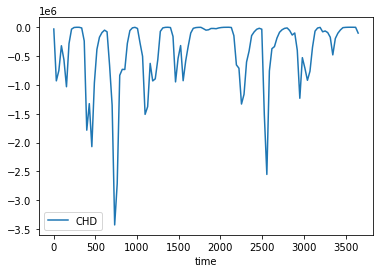

In [13]:
# check the output
csv = os.path.join(sim_path,'chd_flow.csv')
option1 = pd.read_csv(csv)
option1.plot(x='time');

# Option 2
## Using lr2series to create the ts file

### Has the advantage that lr2series can be integrated into a PEST workflow.

In [14]:
# use LR2SERIES to create the ts file
rch_ts = lm.lr2series.TimeSeries(ts_file='rch.ts', workspace=lm_workspace, lr_models=[lr_lu1], ts_names=['rch'], lumprem_output_cols=['net_recharge'],methods=['linearend'], div_delta_t=True)

rch_ts.write_ts()

# get the ts name to pass to flopy
# lr2series will write as timeseries name as 'ts_name'+'_'+'model_name' for each lr_model and ts_name provided. 
# in this case: 'rch' + 'lu1': 'rech_lu1'

# print a list of model names in rch_ts
for i in range(len(rch_ts.lr_models)):
    print(rch_ts.lr_models[i].lumprem_model_name)

ts_name = 'rch_lu1'

MF6 timeseries file .\flopy\lumprem\rch.ts.in written to:
.\flopy\lumprem\rch.ts.in
 Enter name of LR2SERIES control file:  
 - reading file rch.ts.in...
 
 - reading LUMPREM output file lr_lu1.out...
 - file lr_lu1.out read ok.
 - writing file rch.ts...
 - file rch.ts written ok.
 
 - file rch.ts.in read ok.

lu1


In [15]:
# setup the recharge package with the new ts name

rchspd={}
rchspd_arr =[]

for row in range(nrow):
    for col in range(ncols):
        rchspd_arr.append(((0, row, col), ts_name, 1, 'rch'))


for sp in range(len(tdis_rc)):
        rchspd[sp] = rchspd_arr


rch = flopy.mf6.ModflowGwfrch(model, filename='{}_1.rch'.format(model_name), 
                            pname='rch_1', fixed_cell=True,
                            auxiliary='MULTIPLIER', auxmultname='MULTIPLIER',
                            print_input=True, print_flows=True, 
                            save_flows=True, boundnames=True,
                            maxbound=84, stress_period_data=rchspd)


# flopy requires that ou initilize a ts object to tell it which .ts file to read
#initialize the ts 
rch.ts.initialize(filename='rch.ts')


sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package chd_0...
    writing package obs_0...
    writing package rch_1...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 150 based on size of stress_period_data
    writing package ts_0...


In [16]:
#copy lumprem ts file intot the flopy folder
import shutil
from shutil import copyfile

lumprem_ts = os.path.join(lm_workspace, 'rch.ts')
flopy_ts = os.path.join(sim_path, 'rch.ts')

shutil.move(lumprem_ts, flopy_ts)
#shutil.move(modelts, modelts2)

'flopy\\mf6model\\rch.ts'

In [17]:
# run it again
sim.run_simulation()

FloPy is using the following  executable to run the model: C:\Program Files\MODFLOW\mf6.2.0\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to th

(True, [])

## Note how the flow values are different in this case. LR2SERIES distributes volumes over time if the div_time option is selected.

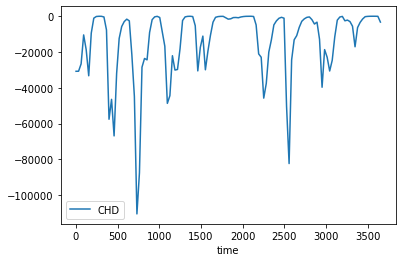

In [18]:
# check the output
csv = os.path.join(sim_path,'chd_flow.csv')
option2 = pd.read_csv(csv)

option2.plot(x='time');